<strong>Prendre le fichier geoJSON et en faire un dataframe avec une colonne correspondant au nom du centre de réanimation, une colonne latitude et une colonne longitude et chaque ligne est un point

In [12]:
import geopandas as gpd

gdf = gpd.read_file("../data/reanimation.geojson")
gdf['latitude'] = gdf['geometry'].y
gdf['longitude'] = gdf['geometry'].x
gdf['name'] = gdf['name']

df = gdf[["name","latitude","longitude"]]

df.to_csv("points.csv",index=False, encoding="utf-8")

<strong>Algorithme des K-means avec modification du CSV points.csv en ajoutant une colonne avec le numéro du cluster associé au point</strong>

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Générer des données aléatoires
X = np.array(df[["latitude", "longitude"]])

# Initialiser l'algorithme des K-means
best_k = 1
best_preds = None
best_centroids = None
best_score = -1
for k in range(2, 11):
    # Exécuter l'algorithme sur les données avec k clusters
    kmeans = KMeans(n_clusters=k, n_init=10).fit(X)

    # Prédire le cluster associé à chaque point
    preds = kmeans.predict(X)

    # Obtenir les centroïdes des clusters
    centroids = kmeans.cluster_centers_

    # Calculer le coefficient de silhouette pour chaque itération
    score = silhouette_score(X, preds)
    print("For k = {}, silhouette score is {}".format(k, score))

    if score > best_score:
        best_k = k
        best_preds = preds
        best_centroids = centroids
        best_score = score

print("\nBest silhouette score is {} with {} clusters".format(best_score, best_k))

# Afficher les labels prédits pour chaque point
df["cluster"] = best_preds
df.to_csv("points.csv", index=False, encoding="utf-8")


For k = 2, silhouette score is 0.4705550423394552
For k = 3, silhouette score is 0.5131730940370476
For k = 4, silhouette score is 0.5146615937475431
For k = 5, silhouette score is 0.5414770635373216
For k = 6, silhouette score is 0.5443784453095634
For k = 7, silhouette score is 0.489238594252879
For k = 8, silhouette score is 0.49188621467784976
For k = 9, silhouette score is 0.5176470223503474
For k = 10, silhouette score is 0.5182642204687007

Best silhouette score is 0.5443784453095634 with 6 clusters


C:\Users\paulp\AppData\Local\Temp\ipykernel_5356\2951680727.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = best_preds


<strong>Affichage des clusters et de leur centroïde avec Matplotlib

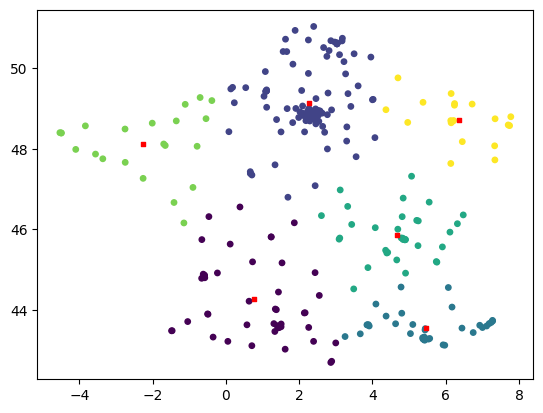

In [14]:
import matplotlib.pyplot as plt

# Affichage des clusters
plt.scatter(X[:,1], X[:,0], s = 15, c = best_preds)
plt.scatter(best_centroids[:, 1], best_centroids[:, 0], s = 10, c = 'r', marker='s')
plt.show()

<strong>Créer un dataframe avec les centroïdes et leurs clusters associés</strong>

In [15]:
import pandas as pd
centroids = best_centroids.tolist()
for i in range(len(centroids)):
    centroids[i].append(i)
    centroids[i].insert(0, "Centroïde_"+str(i))
print(centroids)

df_centroids = pd.DataFrame(centroids, columns=["name","latitude","longitude","cluster"])
df_centroids.to_csv("centroids.csv", index=False, encoding="utf-8")


[['Centroïde_0', 44.26092385957447, 0.7799167702127661, 0], ['Centroïde_1', 49.13973150076923, 2.268615294615384, 1], ['Centroïde_2', 43.55339379756097, 5.465806873170732, 2], ['Centroïde_3', 45.870407557142855, 4.683624474285714, 3], ['Centroïde_4', 48.117633022727276, -2.2627067999999997, 4], ['Centroïde_5', 48.71504104, 6.366201865, 5]]


<strong>Créer un fichier geoJSON à partir du csv créer avec les points (Inutile)</strong>

In [16]:
# !pip3 install pandas_geojson
from pandas_geojson import to_geojson
from pandas_geojson import write_geojson

geo_json = to_geojson(df=df, lat='latitude', lon='longitude',
                 properties=['name','cluster'])
write_geojson(geo_json, filename='points.geojson', indent=4)
# pts_geojson = gpd.read_file("points.geojson")  # permet d'afficher sans problème d'encodage le fichier geoJSON


<strong>Ajouter les centroïdes dans le fichier geojson points.geojson et créer un dataframe avec points et centroïdes</strong>

In [17]:
df_all = df.append(df_centroids)

df_all.to_csv("points+centroides.csv", index=False, encoding="utf-8")

geo_json = to_geojson(df=df_all, lat='latitude', lon='longitude',
                 properties=['name','cluster'])
write_geojson(geo_json, filename='points+centroides.geojson', indent=4)

C:\Users\paulp\AppData\Local\Temp\ipykernel_5356\167258032.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df.append(df_centroids)


<strong>Essayer de créer un fichier geoJSON avec une liste de liste de test correspondant à plusieurs tournées d'un cluster</strong>

In [23]:
import geojson
from ..algo_TSP.algoTSP.ipynb import algo_TSP

def create_tuple(row):
        return (row['longitude'], row['latitude'])  #je met d'abord longitude puis latitude car le fichier geojson prend des coordonnées avec ce format [longitude, latitude]

#Ce bloc va permettre de créer un dictionnaire qui aura la forme de ce qu'il y a en sortie de l'algo TSP
dict_tournees = {}
for i in range(0,best_k):
    # Prend la liste des noms (identifiants) et divise cette liste en plusieurs parties pour ressembler à ce qu'il y aura en sortie de l'algo TSP
    ex_list = df.loc[df['cluster'] == i, 'name'].values
    ex_list = np.array_split(ex_list, 4)

    # Change le format de numpy à une liste normale
    new_list = []
    for l in ex_list:
        l = l.tolist()
        new_list.append(l)

    #Je crée un dictionnaire qui ressemblera à ce qu'il y aura en sortie de l'algorithme TSP
    dict_tournees[i] = new_list

print(dict_tournees)
    
# --------- CODE POUR CREER LE FICHIER GEOJSON A PARTIR DU DICTIONNAIRE DU TSP ---------
features = []

for k in range(0, best_k):
    
    # Créer une liste finale où il y aura à l'intérieur l'ensemble des tuples
    l_finale = []
    for l in dict_tournees[k]:  #créer la liste de tuples des pts de geolocaliation
        result = df_all.loc[df_all['name'].isin(l)]
        tuples = result.apply(create_tuple, axis=1).tolist()
        l_finale += tuples

    points = l_finale
    line = geojson.LineString(points)

    feature = geojson.Feature(geometry=line)
    feature["properties"] = {"cluster":k}
    features.append(feature)
    print(feature)


# Créer une feature collection à partir de la liste de features
feature_collection = geojson.FeatureCollection(features)

# Écrire la feature collection dans un fichier geoJSON
with open('test.geojson', 'w') as f:
    geojson.dump(feature_collection, f, indent=4)

ImportError: attempted relative import with no known parent package

Test algorithme EM (gaussianmixture)

For k = 2, silhouette score is 0.46345832590815367
For k = 3, silhouette score is 0.4867032410748757
For k = 4, silhouette score is 0.5009142229472779
For k = 5, silhouette score is 0.5193693292490983
For k = 6, silhouette score is 0.35183659127882494
For k = 7, silhouette score is 0.3181220166072465
For k = 8, silhouette score is 0.31271529164019357
For k = 9, silhouette score is 0.36962144427118393
For k = 10, silhouette score is 0.2661414363874027

Best silhouette score is 0.5193693292490983 with 5 clusters
Moyennes des distributions:
[[ 4.83477745e+01  7.58006517e+00]
 [ 4.72564399e+01  1.80603482e+00]
 [ 4.33553376e+01  5.74002446e+00]
 [ 4.88474839e+01  2.34664402e+00]
 [ 4.47416955e+01 -5.85955648e-01]
 [ 4.89491571e+01  1.42370665e-02]
 [ 4.35730272e+01  2.86181523e+00]
 [ 4.88707637e+01  6.03025586e+00]
 [ 4.57212110e+01  5.04174518e+00]
 [ 5.05909422e+01  2.86455836e+00]]
Covariances des distributions:
[[[ 1.57411001e-01  7.48833046e-02]
  [ 7.48833046e-02  3.95823797e-02]]



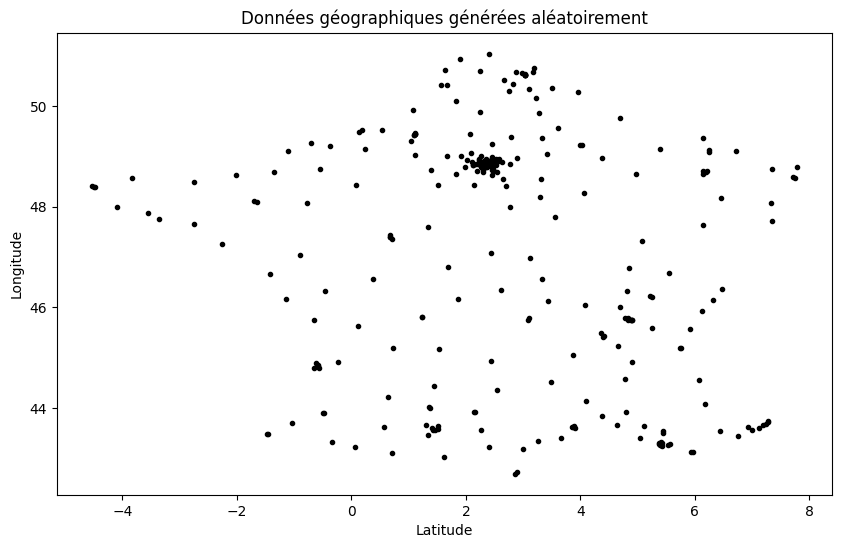

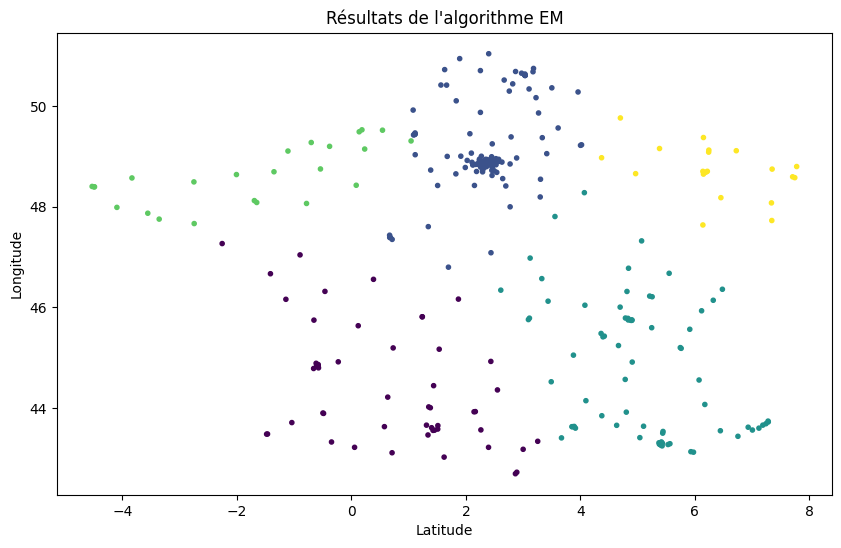

In [ ]:
# Importer les bibliothèques nécessaires
from sklearn.mixture import GaussianMixture
import pandas as pd
from sklearn.metrics import silhouette_score


X = pd.read_csv("points.csv", encoding="utf-8")[["latitude", "longitude"]].values
# print(X)

# Afficher les données générées sur un graphique
plt.figure(figsize=(10,6)) # créer une figure avec une taille donnée
plt.scatter(X[:,1], X[:,0], c='black', marker='.') # tracer les points avec une couleur et un marqueur donnés
plt.xlabel('Latitude') # ajouter un label pour l'axe des x
plt.ylabel('Longitude') # ajouter un label pour l'axe des y
plt.title('Données géographiques générées aléatoirement') # ajouter un titre au graphique

# Appliquer l'algorithme EM avec le nombre de clusters
best_k = 1
best_preds = None
best_score = -1
for k in range(2, 11):
    # Exécuter l'algorithme sur les données avec k clusters
    gm = GaussianMixture(n_components=k).fit(X)

    # Prédire le cluster associé à chaque point
    preds = gm.predict(X)

    # Calculer le coefficient de silhouette pour chaque itération
    score = silhouette_score(X, preds)
    print("For k = {}, silhouette score is {}".format(k, score))

    if score > best_score:
        best_k = k
        best_preds = preds
        best_score = score

print("\nBest silhouette score is {} with {} clusters".format(best_score, best_k))

# Afficher les résultats de l'algorithme EM sur un autre graphique
plt.figure(figsize=(10,6)) # créer une autre figure avec une taille donnée
plt.scatter(X[:,1], X[:,0], c=best_preds, marker='.') # tracer les points avec une couleur correspondant au cluster prédit et un marqueur donné
plt.xlabel('Latitude') # ajouter un label pour l'axe des x
plt.ylabel('Longitude') # ajouter un label pour l'axe des y
plt.title('Résultats de l\'algorithme EM') # ajouter un titre au graphique

# Afficher les paramètres des distributions estimés par l'algorithme EM 
print('Moyennes des distributions:')
print(gm.means_)
print('Covariances des distributions:')
print(gm.covariances_)
